In [1]:
#import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.inspection import permutation_importance
import sklearn.metrics as metrics

import xgboost as xgb

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

In [2]:
# Load dicom dataframe
df = pd.read_feather('../../Data/cleaned_dicom_df.feather')

# Get all lines where BodyPart is Ganzkörper and SliceCount is greater than 600
df = df[((df['BodyPart'] == 'Ganzkörper') | (df['BodyPart'] == 'Stamm')) & (df['SliceCount'] > 400)]

print(df.shape)
df.head()

(87, 12)


,PatientId,PatientAge,PatientSex,PatientWeight,PatientSize,BodyPart,Rows,Columns,SliceCount,PixelSpacing,SliceThickness,PixelArrayFile
0,ANONYM-XT8UJZ,64,M,80.0,1.81,Ganzkörper,512,512,487,0.976562,4.0,Scan_1.npy
1,ANONYM-XT8UJZ_1,56,M,73.0,1.71,Stamm,512,512,567,1.171875,3.0,Scan_2.npy
4,ANONYM-XT8UJZ_3,77,F,74.0,1.63,Stamm,512,512,567,1.171875,3.0,Scan_5.npy
6,ANONYM-XT8UJZ_5,76,F,77.0,1.63,Stamm,512,512,568,1.171875,3.0,Scan_7.npy
10,ANONYM-XT8UJZ_9,51,F,67.0,1.72,Stamm,512,512,567,1.171875,3.0,Scan_11.npy


In [3]:
# Load Pixelarray
def load_pixel_array(scan_id):
    path = f'../../Data/PixelArray/{scan_id}'
    return np.load(path)

In [4]:
# make of each pixel array a histogram
def make_histogram(pixel_array):
    return np.histogram(pixel_array, bins=256, range=(0, 256))[0]

In [5]:
X = df['PixelArrayFile'].apply(load_pixel_array).map(make_histogram)
y = df['PatientWeight']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# train a xgboost model with mean absolute error as objective
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(np.stack(X_train.values), y_train)

# predict the test set
y_pred = model.predict(np.stack(X_test.values))

# calculate the mean absolute error
mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 7.947758144802517


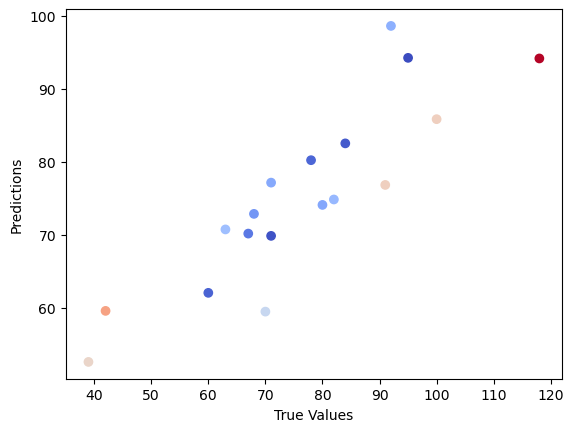

In [28]:
plt.scatter(y_test, y_pred, c=np.abs(y_test - y_pred), cmap='coolwarm')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

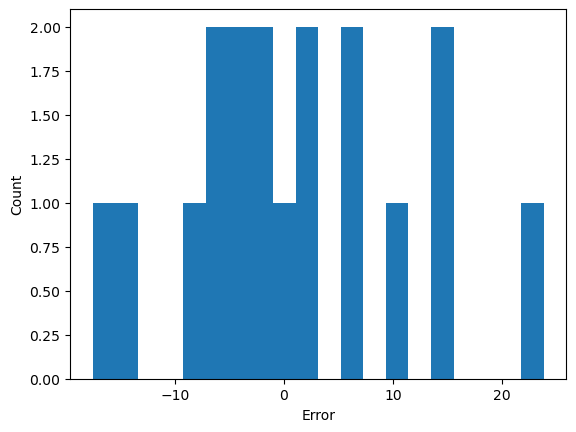

In [33]:
# make a histogram of the errors
plt.hist(y_test - y_pred, bins=20)
plt.xlabel('Error')
plt.ylabel('Count')
plt.show()